# Northwestern MOT Camera Setup
Camera parameters tbd, but geometry set by numbers in: https://docs.google.com/document/d/1gmqzoTKaecD3fDk6Jl7cKynLtw8270DmXRP-4g8IUmw/edit

8 possible camera positions. In the doc, X (1,2) + Y (3,4) correspond to the two diagonals, Z is the front (5)/back (6) of the chamber, right is right (7), pump is at the end of the long baseline (8).


## Test description
- unified sensor size
- pin hole with real image

- Current camera setup: X1: T1, X2: T2, Y1: L, Z1: F

# Software
A few modifications needed to gradoptics code for flexibility, can be found in the version on https://github.com/Magis-slac/gradoptics/tree/sean_edits

will be merged to main soon. Don't forget to pip install the repo! `pip install -e .` from the top level gradoptics directory

In [1]:
import gradoptics as optics
from gradoptics.transforms.simple_transform import SimpleTransform
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

/projects/p30957/envs/pytorch-1.11-py38-alt-2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inch_to_m(inch):
    # 1 in is 2.54 cm
    return 0.0254*inch

## Camera parameters
Somewhat tbd. For now let's just put in some filler focal lengths (`f`), magnifications (`m`), numerical apertures (`na`). We do know the positions roughly -- let's define the coordinate system as (0, 0, 0) at the center of the MOT, with the x-axis along the pump/right window baseline (positive pointing right), z-axis vertical, y-axis in and out of the page (sorry that this doesn't correspond to the names, but it makes the most sense to me!).

We assume that the X/Y cameras (1,2,3,4) are tilted at a 45 degree angle from the x-axis, to be refined.

In [3]:
obj_pos = torch.tensor([0., 0., 0.])

# Distances in m
#camera_dist_x1 = inch_to_m(5)
#camera_dist_x2 = inch_to_m(.5)
#camera_dist_y1 = inch_to_m(1.5)
#camera_dist_z1 = inch_to_m(.5)

camera_dist_x1 = inch_to_m(5)
camera_dist_x2 = inch_to_m(2.5)
camera_dist_y1 = inch_to_m(3.5)
camera_dist_z1 = inch_to_m(2.5)

x1_to_center = inch_to_m(14.5)
x2_to_center = inch_to_m(14.5)
y1_to_center = inch_to_m(17.)
z1_to_center = inch_to_m(11.5)

# Angle from positive x-axis
angle_x1 = np.radians(37.)
angle_x2 = np.radians(45.+180.)
angle_y1 = np.radians(-45.)
angle_y2 = np.radians(-53.+180)



camera_params = [
    {'name' : 'X_1', 
     'position' : ((x1_to_center+camera_dist_x1)*np.cos(angle_x1), 
                   0., (x1_to_center+camera_dist_x1)*np.sin(angle_x1)),
     'orientation' : (0, angle_x1+np.pi, 0), 
     'm' : 0.1, 
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':(640,900)},
    
    {'name' : 'X_2', 
     'position' : ((x2_to_center+camera_dist_x2)*np.cos(angle_x2), 
                   0., (x2_to_center+camera_dist_x2)*np.sin(angle_x2)),
     'orientation' : (0, angle_x2+np.pi, 0),
     'm' : 0.089,
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':(1300,1000)},
    
    {'name' : 'Y_1', 
     'position' : ((y1_to_center+camera_dist_y1)*np.cos(angle_y1),
                   0, (y1_to_center+camera_dist_y1)*np.sin(angle_y1)),
     'orientation' : (0, angle_y1+np.pi, 0), 
     'm' : 0.088, 
     'aperture' : inch_to_m(2.),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':(1000,800)},
    
    
    {'name' : 'Z_1', 
     'position' : (0, (z1_to_center+camera_dist_z1), 0,),
     'orientation' : (0, 0, -np.pi/2),
     'm' : 0.11,
     'aperture' : inch_to_m(2.*2.4/3.45),
     'pixel_size':(3.45e-06, 3.45e-06),
     'resolution':(1050,700)}
    
]

In [4]:
def calculate_focal_length(m, obj_distance):
    f =  obj_distance / ((1 / m) + 1)

    return f

In [5]:
def calculate_obj_distance(obj_pos, camera_pos):
    return torch.sqrt(((torch.tensor(camera_pos)-obj_pos)**2).sum()).item()

In [6]:
for i in range(len(camera_params)):
    camera_params[i]['obj_dist'] = calculate_obj_distance(obj_pos, camera_params[i]['position'])
    camera_params[i]['f'] = calculate_focal_length(camera_params[i]['m'], 
                                                   camera_params[i]['obj_dist'])
    camera_params[i]['na'] = camera_params[i]['aperture']/camera_params[i]['f']
    

In [7]:
for i in range(len(camera_params)):
    print(camera_params[i])

{'name': 'X_1', 'position': (0.39556416812642414, 0.0, 0.2980789809672094), 'orientation': (0, 3.787364476827695, 0), 'm': 0.1, 'aperture': 0.0508, 'pixel_size': (3.45e-06, 3.45e-06), 'resolution': (640, 900), 'obj_dist': 0.49529999999999996, 'f': 0.04502727272727272, 'na': 1.1282051282051284}
{'name': 'X_2', 'position': (-0.30532870811635127, 0.0, -0.30532870811635116), 'orientation': (0, 7.0685834705770345, 0), 'm': 0.089, 'aperture': 0.0508, 'pixel_size': (3.45e-06, 3.45e-06), 'resolution': (1300, 1000), 'obj_dist': 0.43179999999999996, 'f': 0.03528943985307621, 'na': 1.4395241242564443}
{'name': 'Y_1', 'position': (0.3681905009638353, 0, -0.36819050096383527), 'orientation': (0, 2.356194490192345, 0), 'm': 0.088, 'aperture': 0.0508, 'pixel_size': (3.45e-06, 3.45e-06), 'resolution': (1000, 800), 'obj_dist': 0.5207, 'f': 0.042115441176470585, 'na': 1.206208425720621}
{'name': 'Z_1', 'position': (0, 0.35559999999999997, 0), 'orientation': (0, 0, -1.5707963267948966), 'm': 0.11, 'apert

In [8]:
# Atom cloud
light_source = optics.LightSourceFromDistribution(optics.AtomCloud(phi=0.1, w0=0.005, k_fringe=0,
                                                                   position=[0., 0., 0.]))

In [9]:
# Scene
scene = optics.Scene(light_source)

for camera in camera_params:
    transform = SimpleTransform(*camera['orientation'], camera['position'])
    lens = optics.PerfectLens(f=camera['f'], m=camera['m'], na=camera['na'],
                              position = camera['position'],
                              transform=transform)
                              
    rel_position = torch.tensor([-camera['f'] * (1 + camera['m']), 0, 0])                       
    rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))
    
    sensor_position = torch.tensor(camera['position']) + rot_position[:-1]
    viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))
    
    # For now assume all 
    # https://www.flir.com/products/blackfly-gige/?model=BFLY-PGE-31S4M-C&vertical=machine+vision&segment=iis
    # can generalize later
    sensor = optics.Sensor(position=sensor_position, viewing_direction=tuple(viewing_direction.numpy()),
                           resolution=camera['resolution'], pixel_size=camera['pixel_size'],
                           poisson_noise_mean=2.31, quantum_efficiency=0.72)
    scene.add_object(sensor)
    scene.add_object(lens)

## Add windows
Need to modify the `optics.Window` object a bit to allow for the possibility of rotation. Distances/orientations should be as given for cameras above, minus additional offsets. From the Google doc, other relevant info is:

Diameter of the windows:
- Pump: 5”
- Right window: 5”
- X/Y/Z: 2.69”

Thickness of the windows: 0.25 in

Refractive Index of the windows:
- 1.466691@Wavelength 435.957 nm
- 1.463123@Wavelength 486.269 nm

In [10]:
n_glass = 1.466691
window_params = [
    {'name' : 'X_1', 
     'position' : (x1_to_center*np.cos(angle_x1), 
                   0., x1_to_center*np.sin(angle_x1)),
     'orientation' : (0, angle_x1, 0),
     'diameter' : inch_to_m(2.69),
     'thickness': inch_to_m(0.25)},
    
    {'name' : 'X_2', 
     'position' : (x2_to_center*np.cos(angle_x2), 
                   0., x2_to_center*np.sin(angle_x2)),
     'orientation' : (0, angle_x2, 0),
     'diameter' : inch_to_m(2.69),
     'thickness': inch_to_m(0.25)},
    
    {'name' : 'Y_1', 
     'position' : (y1_to_center*np.cos(angle_y1),
                   0., y1_to_center*np.sin(angle_y1)),
     'orientation' : (0, angle_y1, 0),
     'diameter' : inch_to_m(2.69),
     'thickness': inch_to_m(0.25)},

    
    {'name' : 'Z_1', 
     'position' : (0., z1_to_center, 0.),
     'orientation' : (0, 0, np.pi/2),
     'diameter' : inch_to_m(2.69),
     'thickness': inch_to_m(0.25)}
]

In [11]:
for window in window_params:
    window_rad = torch.tensor(window['position']).norm().item()
    
    left_window_distance = window_rad - window['thickness']/2.
    right_window_distance = window_rad + window['thickness']/2.
    
    window = optics.Window(left_window_distance, right_window_distance, n_ext=1.000293, 
                           n_glass=n_glass, diameter=window['diameter'], orientation=window['orientation'])

    scene.add_object(window)

/projects/p30957/envs/pytorch-1.11-py38-alt-2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650922114512/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


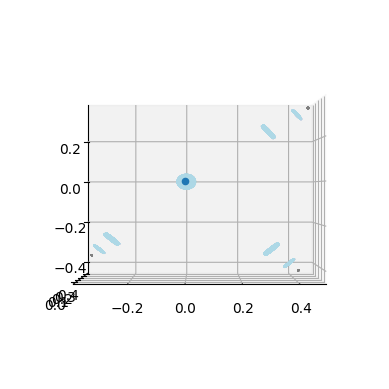

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)
ax.view_init(0, -90)

## Let's try simulating some images

We'll use backward ray tracing here, since that's what we'll use for a reconstruction. This samples rays at each pixel and traces them through the scene. A few key aspects:

- We need to define an integrator which tells us how to sample to integrate the contribution from the atomic density
- We need to define a bounding sphere which contains the atom cloud (defines where we do the integral)
- An implementation quirk -- we need to enclose the whole scene in a bounding sphere so that we don't have rays going off to infinity

In [13]:
# Define an integrator
from gradoptics.integrator import HierarchicalSamplingIntegrator
integrator = HierarchicalSamplingIntegrator(64, 64)


# Define a bounding shape to integrate in
scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.03, 
                                                         xc=0, yc=0, zc=0)

# Enclose the scene in a large bounding sphere
scene.add_object(optics.BoundingSphere(xc=0, yc=0, zc=0, radii=10.))

In [14]:
pixel_batch = 200000
camera_intensities_all = []
for i,obj in enumerate(scene.objects):
    if type(obj) == optics.Sensor:
        sensor = scene.objects[i]
        lens = scene.objects[i+1]
        
        # Define pixel indices
        idxs = torch.cartesian_prod(torch.arange(sensor.resolution[0]//2, -sensor.resolution[0]//2, -1), 
                            torch.arange(sensor.resolution[1]//2, -sensor.resolution[1]//2, -1))

        pix_x, pix_y = idxs.T

        # Batch over them for rendering -- I used a large GPU
        batch_pix_x = pix_x.split(pixel_batch)
        batch_pix_y = pix_y.split(pixel_batch)

        intensities_all = []
        
        device = 'cuda'
        lens_pos = scene.objects[i+1].transform.transform[:-1, -1].to(device)       
        
        for j in tqdm(range(len(batch_pix_x))):
            nb_pixels = len(batch_pix_x[j])
                        
            origins = torch.zeros((nb_pixels,3),device = device,dtype = torch.float64)
            origins[:,0] = (batch_pix_x[j].to(device))* sensor.pixel_size[0]
            origins[:,1] = (batch_pix_y[j].to(device))* sensor.pixel_size[1]
            origins = sensor.c2w.apply_transform_(origins.reshape(-1, 3)).reshape((nb_pixels, 3))
            pA = 1 / (sensor.resolution[0] * sensor.pixel_size[0] * sensor.resolution[1] * sensor.pixel_size[1])         
            
            directions = lens_pos - origins
            directions = directions/torch.norm(directions, dim=1, keepdim=True)  
           
            outgoing_rays = optics.Rays(origins, directions, device='cuda')
            intensities_all.append(optics.backward_ray_tracing(outgoing_rays,scene, scene.light_source,integrator, max_iterations=6))

        camera_intensities = torch.cat(intensities_all).reshape(sensor.resolution)
        camera_intensities_all.append(camera_intensities.clone())

100%|██████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.49it/s]


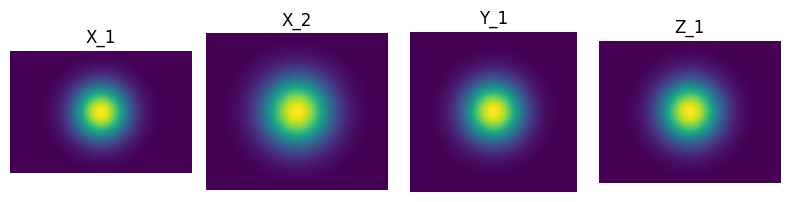

In [15]:
%matplotlib inline
fig, ax = plt.subplots(1,4, figsize=(8, 2))
for i in range(len(camera_intensities_all)):
    im = ax[i].imshow(camera_intensities_all[i].cpu().T)
    ax[i].set_title(f"{camera_params[i]['name']}")
    ax[i].axis('off')
plt.tight_layout() 
#plt.savefig('NW_setup_images_1mm_sep.png', dpi=1000)

## Just a quick plot to see what the pdf we're imaging is

In [16]:
n_side = 200
grid = torch.cartesian_prod(torch.linspace(-0.03, 0.03, n_side), 
                            torch.linspace(-0.03, 0.03, n_side),
                            torch.linspace(-0.03, 0.03, n_side))

In [17]:
pdf_vals = scene.light_source.distribution.pdf(grid).reshape((n_side,n_side,n_side))

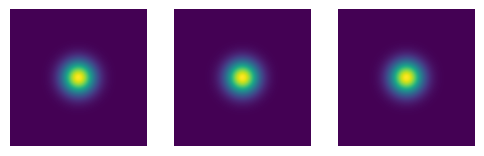

In [18]:
fig, ax = plt.subplots(1,3, figsize=(6, 2))
for i in range(3):
    ax[i].imshow(pdf_vals.sum(dim=i).T)
    ax[i].axis('off')

In [19]:
import pickle
with open("NW_mot_scene_components.pkl", "wb") as f:
    pickle.dump(scene.objects, f)
    

In [20]:
'''
# use simulation
with open("NW_mot_images.pkl", "wb") as f:
    pickle.dump(camera_intensities_all, f)
    '''

In [12]:
import torch
import pickle
# use real data
import cv2
import matplotlib.pyplot as plt
T1 = torch.tensor(cv2.imread('T1_1.png',0).T, dtype=torch.float32) 
T2 = torch.tensor(cv2.imread('T2_1.png',0).T, dtype=torch.float32)
L = torch.tensor(cv2.imread('L_1.png',0).T, dtype=torch.float32)
F = torch.tensor(cv2.imread('Fnew_1.png',0).T, dtype=torch.float32)
data_intensities_all = [T1,T2,L,F]

with open("NW_mot_images.pkl", "wb") as f:
    pickle.dump(data_intensities_all, f)

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kwargs)>

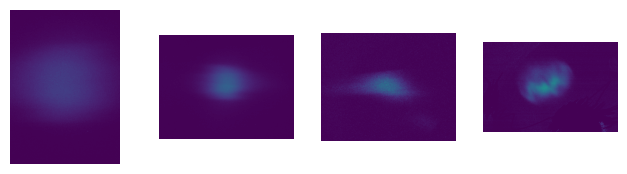

In [22]:
fig, ax = plt.subplots(1,4, figsize=(8, 2))
ax[0].imshow(T1.T)
ax[0].axis('off')
ax[1].imshow(T2.T)
ax[1].axis('off')
ax[2].imshow(L.T)
ax[2].axis('off')
ax[3].imshow(F.T)
ax[3].axis('off')

plt.colorbar

